In [ ]:
import numpy as np

class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        # Weights
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, x, h_prev):
        # Hidden state
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
        # Output (unnormalized)
        y = np.dot(self.Why, h) + self.by
        # Stable softmax
        y -= np.max(y)
        p = np.exp(y) / np.sum(np.exp(y))
        return p, h

    def backward(self, x, target, h, h_prev, p, dh_next, learning_rate=0.1):
        # Output gradient
        dy = np.copy(p)
        dy -= target

        # Gradients w.r.t weights and biases
        dWhy = np.dot(dy, h.T)
        dby = dy

        # Backprop into hidden layer
        dh = np.dot(self.Why.T, dy) + dh_next
        dh_raw = (1 - h ** 2) * dh  # tanh derivative

        dWxh = np.dot(dh_raw, x.T)
        dWhh = np.dot(dh_raw, h_prev.T)
        dbh = dh_raw

        # Next hidden state gradient
        dh_next = np.dot(self.Whh.T, dh_raw)

        # Clip to avoid exploding gradients
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)

        # Update parameters
        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby

        return dh_next

def one_hot(char_idx, vocab_size):
    x = np.zeros((vocab_size, 1))
    x[char_idx] = 1
    return x

def train_rnn(text, epochs=100, hidden_size=100, learning_rate=0.1):
    # Vocabulary mapping
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    char_to_idx = { ch:i for i,ch in enumerate(chars) }
    idx_to_char = { i:ch for i,ch in enumerate(chars) }

    # Initialize RNN
    rnn = SimpleRNN(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size)

    smooth_loss = -np.log(1.0/vocab_size)*len(text)

    for epoch in range(epochs):
        h_prev = np.zeros((hidden_size, 1))
        loss = 0

        for t in range(len(text) - 1):
            x = one_hot(char_to_idx[text[t]], vocab_size)
            target = one_hot(char_to_idx[text[t+1]], vocab_size)

            p, h = rnn.forward(x, h_prev)
            loss += -np.log(p[char_to_idx[text[t+1]], 0])

            dh_next = np.zeros_like(h_prev)
            dh_next = rnn.backward(x, target, h, h_prev, p, dh_next, learning_rate)

            h_prev = h

        # Smooth loss
        smooth_loss = smooth_loss * 0.9 + loss * 0.1

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {smooth_loss/len(text):.4f}")

    return rnn, char_to_idx, idx_to_char

def generate_text(rnn, char_to_idx, idx_to_char, seed_char, length=100):
    vocab_size = len(char_to_idx)
    h = np.zeros((rnn.hidden_size, 1))
    x = one_hot(char_to_idx[seed_char], vocab_size)
    result = [seed_char]

    for _ in range(length):
        p, h = rnn.forward(x, h)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        result.append(idx_to_char[idx])
        x = one_hot(idx, vocab_size)

    return ''.join(result)

if __name__ == "__main__":
    # Example usage
    text = "It fills my heart with joy unspeakable to rise in response to the warm and cordial welcome which you have given us."
    rnn, char_to_idx, idx_to_char = train_rnn(text, epochs=500, hidden_size=50, learning_rate=0.1) # make it 5000 epoch to get the better result 
    generated = generate_text(rnn, char_to_idx, idx_to_char, seed_char='h', length=50)
    print(f"Generated: {generated}")


Epoch 0, Loss: 3.2453
Epoch 10, Loss: 2.8377
Epoch 20, Loss: 2.3374
Epoch 30, Loss: 2.3700
Epoch 40, Loss: 2.6497
Epoch 50, Loss: 2.8816
Epoch 60, Loss: 2.9939
Epoch 70, Loss: 3.2015
Epoch 80, Loss: 3.4042
Epoch 90, Loss: 3.5014
Epoch 100, Loss: 3.3833
Epoch 110, Loss: 3.4073
Epoch 120, Loss: 3.4716
Epoch 130, Loss: 3.4739
Epoch 140, Loss: 3.3739
Epoch 150, Loss: 3.3324
Epoch 160, Loss: 3.2977
Epoch 170, Loss: 3.3533
Epoch 180, Loss: 3.2824
Epoch 190, Loss: 3.2212
Epoch 200, Loss: 3.1648
Epoch 210, Loss: 3.2068
Epoch 220, Loss: 3.1752
Epoch 230, Loss: 3.2486
Epoch 240, Loss: 3.1418
Epoch 250, Loss: 3.1565
Epoch 260, Loss: 3.3758
Epoch 270, Loss: 3.1813
Epoch 280, Loss: 3.2732
Epoch 290, Loss: 3.2547
Epoch 300, Loss: 3.2129
Epoch 310, Loss: 3.1267
Epoch 320, Loss: 3.1544
Epoch 330, Loss: 3.1689
Epoch 340, Loss: 3.2692
Epoch 350, Loss: 3.1023
Epoch 360, Loss: 3.1606
Epoch 370, Loss: 3.1595
Epoch 380, Loss: 3.0712
Epoch 390, Loss: 3.0309
Epoch 400, Loss: 2.9994
Epoch 410, Loss: 2.7964
Epo

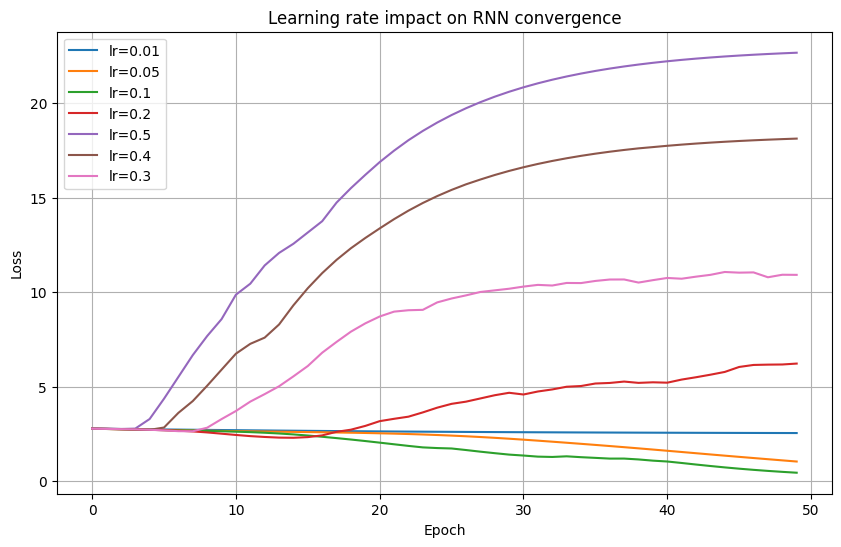

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# (Paste your SimpleRNN, one_hot, generate_text here — unchanged.)

def train_rnn_with_plot(text, hidden_size=50, learning_rates=[0.01, 0.05,0.1, 0.2, 0.5,0.4,0.3], epochs=50):
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    char_to_idx = { ch:i for i,ch in enumerate(chars) }
    idx_to_char = { i:ch for i,ch in enumerate(chars) }

    all_losses = []

    for lr in learning_rates:
        rnn = SimpleRNN(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size)
        smooth_loss = -np.log(1.0/vocab_size)*len(text)
        losses = []

        for epoch in range(epochs):
            h_prev = np.zeros((hidden_size, 1))
            loss = 0

            for t in range(len(text) - 1):
                x = one_hot(char_to_idx[text[t]], vocab_size)
                target = one_hot(char_to_idx[text[t+1]], vocab_size)
                p, h = rnn.forward(x, h_prev)
                loss += -np.log(p[char_to_idx[text[t+1]], 0])
                dh_next = np.zeros_like(h_prev)
                dh_next = rnn.backward(x, target, h, h_prev, p, dh_next, learning_rate=lr)
                h_prev = h

            smooth_loss = smooth_loss * 0.9 + loss * 0.1
            losses.append(smooth_loss / len(text))

        all_losses.append((lr, losses))

    # Plot
    plt.figure(figsize=(10,6))
    for lr, losses in all_losses:
        plt.plot(losses, label=f'lr={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning rate impact on RNN convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    text = "hello world this is a simple rnn example"
    train_rnn_with_plot(text, hidden_size=50, learning_rates=[0.01, 0.05,0.1, 0.2, 0.5,0.4,0.3], epochs=50)


In [26]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class SimpleLSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        
        # Input gate
        self.Wxi = np.random.randn(hidden_size, input_size) * 0.01
        self.Whi = np.random.randn(hidden_size, hidden_size) * 0.01
        self.bi = np.zeros((hidden_size, 1))
        
        # Forget gate
        self.Wxf = np.random.randn(hidden_size, input_size) * 0.01
        self.Whf = np.random.randn(hidden_size, hidden_size) * 0.01
        self.bf = np.zeros((hidden_size, 1))
        
        # Output gate
        self.Wxo = np.random.randn(hidden_size, input_size) * 0.01
        self.Who = np.random.randn(hidden_size, hidden_size) * 0.01
        self.bo = np.zeros((hidden_size, 1))
        
        # Candidate memory
        self.Wxc = np.random.randn(hidden_size, input_size) * 0.01
        self.Whc = np.random.randn(hidden_size, hidden_size) * 0.01
        self.bc = np.zeros((hidden_size, 1))
        
        # Output layer
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.by = np.zeros((output_size, 1))
        
    def forward(self, x, h_prev, c_prev):
        # Gates
        i = sigmoid(np.dot(self.Wxi, x) + np.dot(self.Whi, h_prev) + self.bi)
        f = sigmoid(np.dot(self.Wxf, x) + np.dot(self.Whf, h_prev) + self.bf)
        o = sigmoid(np.dot(self.Wxo, x) + np.dot(self.Who, h_prev) + self.bo)
        g = np.tanh(np.dot(self.Wxc, x) + np.dot(self.Whc, h_prev) + self.bc)
        
        # Cell state
        c = f * c_prev + i * g
        
        # Hidden state
        h = o * np.tanh(c)
        
        # Output prediction
        y = np.dot(self.Why, h) + self.by
        y -= np.max(y)  # for stable softmax
        p = np.exp(y) / np.sum(np.exp(y))
        
        # Save activations for backprop
        self.cache = (i, f, o, g, c, h, c_prev, h_prev, x, p)
        
        return p, h, c

    def backward(self, target, dh_next, dc_next, learning_rate=0.1):
        i, f, o, g, c, h, c_prev, h_prev, x, p = self.cache
        
        # Output loss gradient
        dy = np.copy(p)
        dy -= target
        
        dWhy = np.dot(dy, h.T)
        dby = dy
        
        # Backprop into hidden state
        dh = np.dot(self.Why.T, dy) + dh_next
        
        # Output gate
        do = dh * np.tanh(c)
        do_raw = do * o * (1 - o)
        
        # Cell state
        dc = dh * o * (1 - np.tanh(c)**2) + dc_next
        
        # Forget gate
        df = dc * c_prev
        df_raw = df * f * (1 - f)
        
        # Input gate
        di = dc * g
        di_raw = di * i * (1 - i)
        
        # Candidate
        dg = dc * i
        dg_raw = dg * (1 - g**2)
        
        # Grad w.r.t inputs & previous hidden
        dWxi = np.dot(di_raw, x.T)
        dWhi = np.dot(di_raw, h_prev.T)
        dbi = di_raw
        
        dWxf = np.dot(df_raw, x.T)
        dWhf = np.dot(df_raw, h_prev.T)
        dbf = df_raw
        
        dWxo = np.dot(do_raw, x.T)
        dWho = np.dot(do_raw, h_prev.T)
        dbo = do_raw
        
        dWxc = np.dot(dg_raw, x.T)
        dWhc = np.dot(dg_raw, h_prev.T)
        dbc = dg_raw
        
        # Compute dh_next and dc_next
        dh_next = (np.dot(self.Whi.T, di_raw)
                 + np.dot(self.Whf.T, df_raw)
                 + np.dot(self.Who.T, do_raw)
                 + np.dot(self.Whc.T, dg_raw))
        dc_next = dc * f
        
        # Clip
        for dparam in [dWxi,dWhi,dbi,dWxf,dWhf,dbf,dWxo,dWho,dbo,dWxc,dWhc,dbc,dWhy,dby]:
            np.clip(dparam, -5, 5, out=dparam)
        
        # Update
        self.Wxi -= learning_rate * dWxi
        self.Whi -= learning_rate * dWhi
        self.bi  -= learning_rate * dbi
        
        self.Wxf -= learning_rate * dWxf
        self.Whf -= learning_rate * dWhf
        self.bf  -= learning_rate * dbf
        
        self.Wxo -= learning_rate * dWxo
        self.Who -= learning_rate * dWho
        self.bo  -= learning_rate * dbo
        
        self.Wxc -= learning_rate * dWxc
        self.Whc -= learning_rate * dWhc
        self.bc  -= learning_rate * dbc
        
        self.Why -= learning_rate * dWhy
        self.by  -= learning_rate * dby
        
        return dh_next, dc_next


In [47]:
def train_lstm(text, epochs=100, hidden_size=100, learning_rate=0.1):
    # Vocabulary mapping
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    char_to_idx = { ch:i for i,ch in enumerate(chars) }
    idx_to_char = { i:ch for i,ch in enumerate(chars) }

    lstm = SimpleLSTM(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size)
    smooth_loss = -np.log(1.0/vocab_size)*len(text)

    for epoch in range(epochs):
        h_prev = np.zeros((hidden_size, 1))
        c_prev = np.zeros((hidden_size, 1))
        loss = 0

        for t in range(len(text) - 1):
            x = one_hot(char_to_idx[text[t]], vocab_size)
            target = one_hot(char_to_idx[text[t+1]], vocab_size)

            p, h, c = lstm.forward(x, h_prev, c_prev)
            loss += -np.log(p[char_to_idx[text[t+1]], 0])

            dh_next = np.zeros_like(h)
            dc_next = np.zeros_like(c)
            dh_next, dc_next = lstm.backward(target, dh_next, dc_next, learning_rate)

            h_prev, c_prev = h, c

        smooth_loss = smooth_loss * 0.9 + loss * 0.1

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {smooth_loss/len(text):.4f}")

    return lstm, char_to_idx, idx_to_char

def generate_text_lstm(lstm, char_to_idx, idx_to_char, seed_char, length=100):
    vocab_size = len(char_to_idx)
    h = np.zeros((lstm.hidden_size, 1))
    c = np.zeros((lstm.hidden_size, 1))
    x = one_hot(char_to_idx[seed_char], vocab_size)
    result = [seed_char]

    for _ in range(length):
        p, h, c = lstm.forward(x, h, c)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        result.append(idx_to_char[idx])
        x = one_hot(idx, vocab_size)

    return ''.join(result)
if __name__ == "__main__":
    text = """
hello i am nirav. i like to learn machine learning and deep learning.
i love solving problems and building intelligent systems. 
hello world, this is a wonderful journey of artificial intelligence.
"""
    lstm, char_to_idx, idx_to_char = train_lstm(text, epochs=800, hidden_size=50, learning_rate=0.1)
    generated = generate_text_lstm(lstm, char_to_idx, idx_to_char, seed_char='h', length=50)
    print(f"Generated: {generated}")



Epoch 0, Loss: 3.2780
Epoch 10, Loss: 3.0490
Epoch 20, Loss: 2.9026
Epoch 30, Loss: 2.5880
Epoch 40, Loss: 2.1668
Epoch 50, Loss: 1.5964
Epoch 60, Loss: 1.0087
Epoch 70, Loss: 0.5723
Epoch 80, Loss: 0.2501
Epoch 90, Loss: 0.1088
Epoch 100, Loss: 0.0512
Epoch 110, Loss: 0.0289
Epoch 120, Loss: 0.0198
Epoch 130, Loss: 0.0139
Epoch 140, Loss: 0.0104
Epoch 150, Loss: 0.0088
Epoch 160, Loss: 0.0084
Epoch 170, Loss: 1.2573
Epoch 180, Loss: 0.9199
Epoch 190, Loss: 0.4696
Epoch 200, Loss: 0.2051
Epoch 210, Loss: 0.1041
Epoch 220, Loss: 0.0643
Epoch 230, Loss: 0.0450
Epoch 240, Loss: 0.0609
Epoch 250, Loss: 0.2148
Epoch 260, Loss: 0.1769
Epoch 270, Loss: 0.0776
Epoch 280, Loss: 0.0601
Epoch 290, Loss: 0.0311
Epoch 300, Loss: 0.0203
Epoch 310, Loss: 0.0204
Epoch 320, Loss: 0.0121
Epoch 330, Loss: 0.0072
Epoch 340, Loss: 0.0051
Epoch 350, Loss: 0.0040
Epoch 360, Loss: 0.0034
Epoch 370, Loss: 0.0031
Epoch 380, Loss: 0.0030
Epoch 390, Loss: 0.0027
Epoch 400, Loss: 0.0121
Epoch 410, Loss: 0.0071
Epo